In [7]:
import os
import numpy as np
import pandas as pd
from tod import CSV_Reader, WormViewer
import cv2
import numpy as np
import time
from tqdm import tqdm

from utils import *

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,6)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
csv_path = "./exp/csvs/1049.csv"
vid_path = "./exp/vids/1049.avi"

exp = CSV_Reader(csv_path, vid_path)
interval = 100  # Frame interval for getting frame values

Determining Experiment End


100%|██████████| 25/25 [00:00<00:00, 38.78it/s]

Experiment Done @ Frame 1900


## Get wormcounts in the experiment every X number of frames.
__Then plot this over time to see when the experiment ends / get a count of the number of worms total__

1. Total bounding boxes over x frames
2. Do nms over x frames and see how the total changes over the experiment

In [9]:
counts = []

for i in tqdm(range(0, exp.frame_count, interval)):
    interval_bbs = []
    for n in range(i, i + interval):
        _, bbs = exp.get_worms_from_frame(n)
        interval_bbs.append(bbs)
    ls = np.concatenate(interval_bbs, axis=0)
    counts.append(len(ls) / interval)

    
plt.plot(counts)
    

 16%|█▌        | 4/25 [00:13<01:10,  3.37s/it]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Yolo Worm Count Through The Experiment')

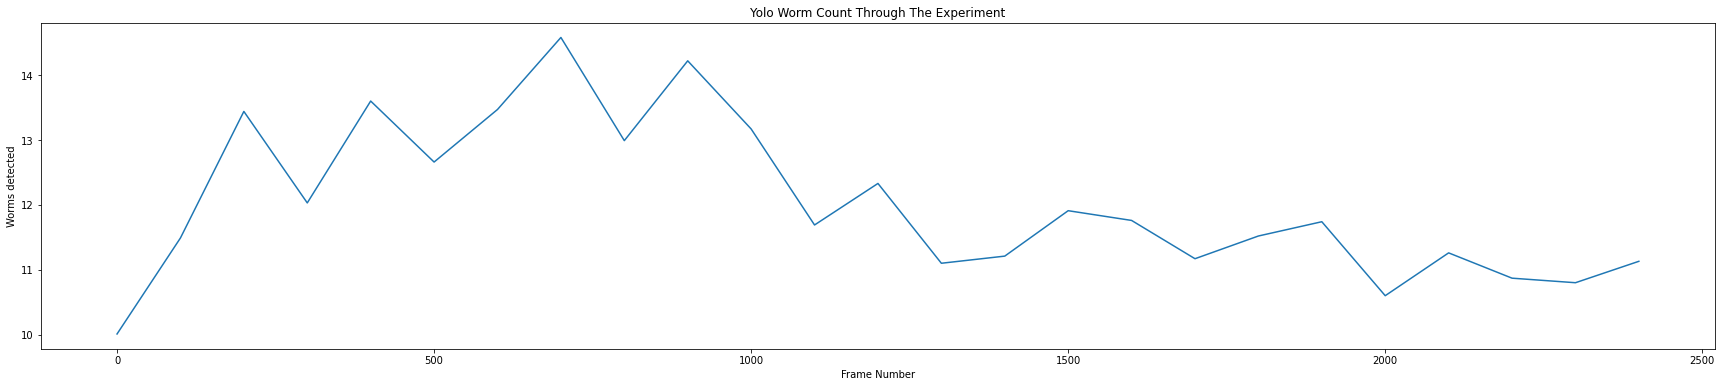

In [44]:
ys = np.arange(0, exp.frame_count, interval)

plt.plot(ys, counts)
plt.xlabel("Frame Number")
plt.ylabel("Worms detected")
plt.title("Yolo Worm Count Through The Experiment") 

In [45]:
counts = []
skip = 10

for i in tqdm(range(0, exp.frame_count, interval)):
    interval_bbs = []
    for n in range(i, i + interval, skip):
        _, bbs = exp.get_worms_from_frame(n)
        interval_bbs.append(bbs)
    ls = np.concatenate(interval_bbs, axis=0)
    nms = non_max_suppression_post(ls, 0.2)
    counts.append(len(nms))

100%|██████████| 25/25 [00:07<00:00,  3.42it/s]


Text(0.5, 1.0, 'Unique Worm Detections Every 100 Throughout The Experiment')

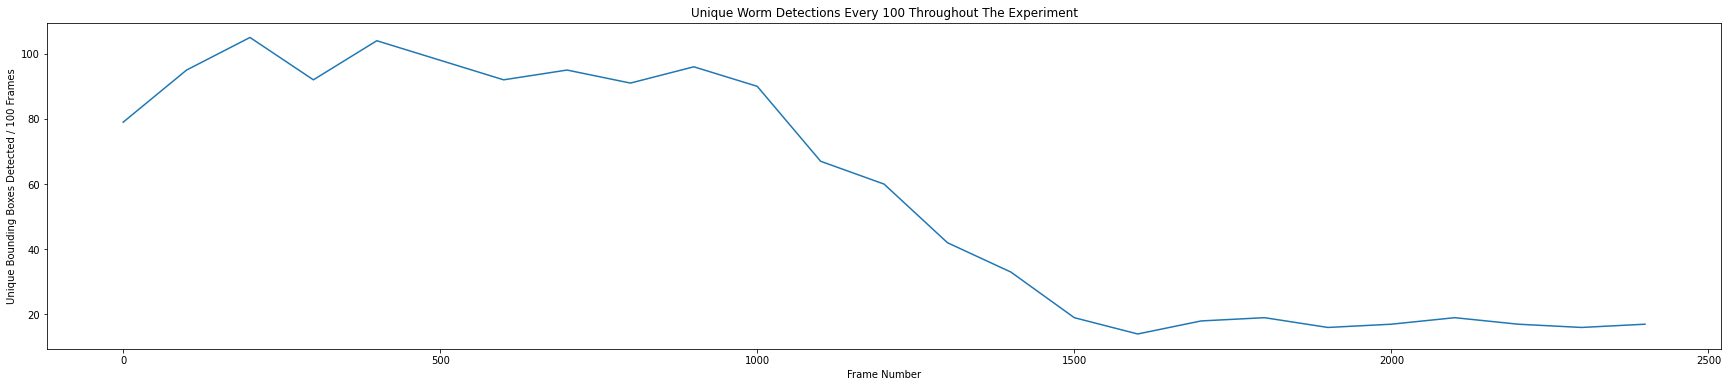

In [46]:
ys = np.arange(0, exp.frame_count, interval)

plt.plot(ys, counts)
plt.xlabel("Frame Number")
plt.ylabel(f"Unique Bounding Boxes Detected / {interval} Frames")
plt.title(f"Unique Worm Detections Every {interval} Throughout The Experiment") 

In [61]:
def nms_counts(outputs: np.ndarray, overlapThresh):
    # if there are no boxes, return an empty list
    boxes = outputs.astype(float)
    # for out in outputs:
    #     x1, y1, x2, y2, = out
    #     fullOutputs.append([x1.tolist(), y1.tolist(), x2.tolist(), y2.tolist(),
    #                         conf.tolist(), cls_conf.tolist()])
    # t = time.time()
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    w = boxes[:, 2]
    h = boxes[:, 3]
    x2 = x1 + w
    y2 = y1 + h
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    cs = []
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
        
        # get the counts for each bounding box.
        cs.append(len(np.where(overlap > overlapThresh)[0]))
        

    return boxes[pick].astype(float), cs

In [62]:
a = nms_counts(ls, 0.2)

b = np.array(a[1])

In [72]:
def stagnant_worms(counts, thresh=5):
    ar = np.array(counts)
    idxs = ar[ar > thresh]
    count = len(idxs)
    return count

stagnant = []
skip = 2

for i in tqdm(range(0, exp.frame_count, interval)):
    interval_bbs = []
    for n in range(i, i + interval, skip):
        _, bbs = exp.get_worms_from_frame(n)
        interval_bbs.append(bbs)
    ls = np.concatenate(interval_bbs, axis=0)
    bbs, counts = nms_counts(ls, 0.6)
    count = stagnant_worms(counts)
    stagnant.append(count)

100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Text(0.5, 1.0, 'Stagnant Worm Count Per 100 Frames')

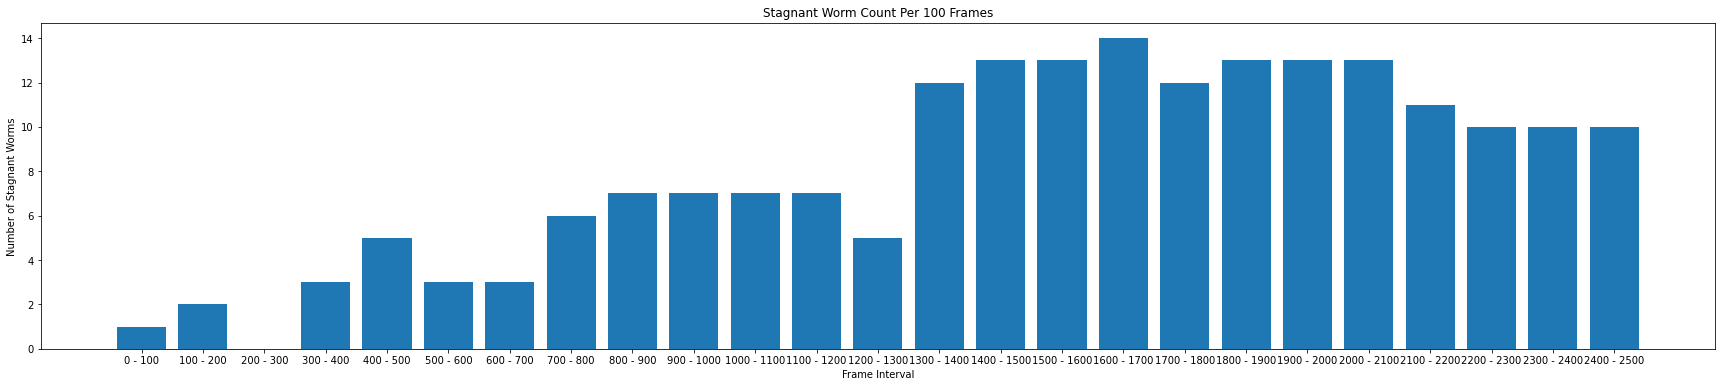

In [74]:
ys = np.arange(0, exp.frame_count, interval)
groups = [f"{y} - {y + interval}" for y in ys]

plt.bar(groups, stagnant, width=0.8)
plt.xlabel("Frame Interval")
plt.ylabel(f"Number of Stagnant Worms")
plt.title(f"Stagnant Worm Count Per {interval} Frames") 

In [85]:
b = [1,2,3,4,5,6,6,6]
b.index(6)



5

## Goal is to make bar graph for new stagnant worms.
### Will add each series of stagnant boudning boxes to a list. Then Run NMS again to eliminate duplicates from the list.

In [51]:
def stagnant_idxs(counts, thresh=25):
    ar = np.array(counts)
    idxs = np.where(ar > thresh)
    return idxs

step = 2
new_stagnant = []
new_count = []

for i in tqdm(range(0, exp.frame_count, interval)):
    interval_bbs = []
    for n in range(i, i + interval, step):
        _, bbs = exp.get_worms_from_frame(n)
        interval_bbs.append(bbs)
    ls = np.concatenate(interval_bbs, axis=0)
    bbs, counts = nms_counts(ls, 0.6)
    idxs = stagnant_idxs(counts)[0]
    
    stagnant_bbs = bbs[idxs].tolist()
#     print(stagnant_bbs)
    
    prev = len(new_stagnant)
    if len(stagnant_bbs) == 0:
        new_count.append(0)
    else:
        new_stagnant += stagnant_bbs
#         print(new_stagnant)
        new_stagnant = nms_counts(np.array(new_stagnant), 0.6)[0].tolist()
        post = len(new_stagnant)

        new_count.append(post - prev)
    

100%|██████████| 25/25 [00:39<00:00,  1.58s/it]


In [52]:
len(counts)


22

Text(0.5, 1.0, 'New Stagnant Worm Count Per 100 Frames')

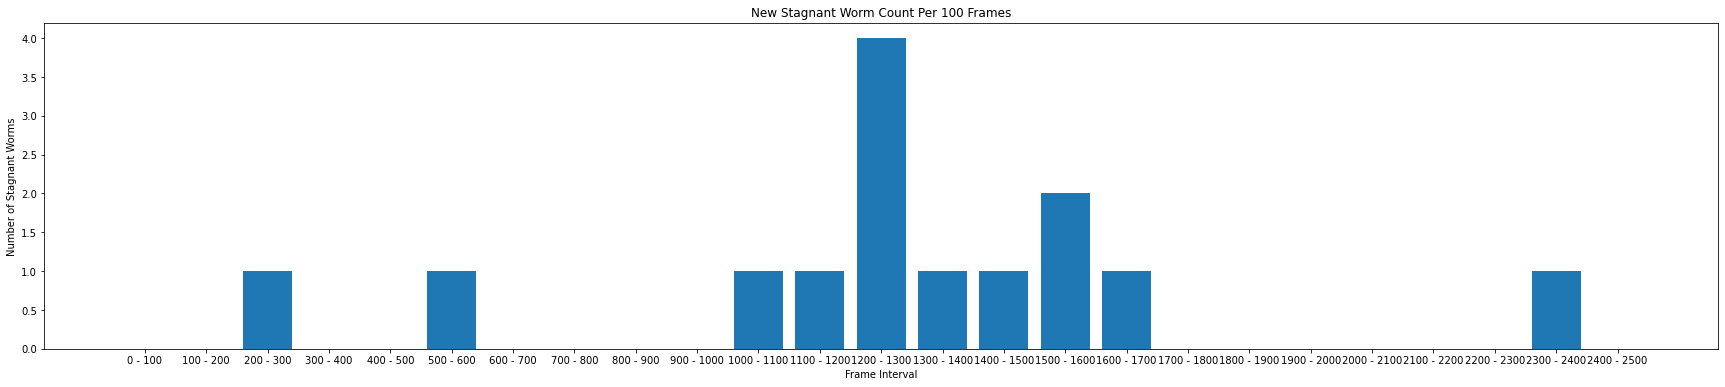

In [53]:
ys = np.arange(0, exp.frame_count, interval)
groups = [f"{y} - {y + interval}" for y in ys]

plt.bar(groups, new_count, width=0.8)
plt.xlabel("Frame Interval")
plt.ylabel(f"Number of Stagnant Worms")
plt.title(f"New Stagnant Worm Count Per {interval} Frames") 

In [38]:
len(new_stagnant)

16

In [36]:
_, bbs = exp.get_worms_from_frame(20)
_, bb2 = exp.get_worms_from_frame(20)

In [12]:
c = np.empty_like(bbs[0])
np.concatenate([bbs, bb2], axis=0)

array([[1193, 615, 30, 19],
       [969, 613, 25, 20],
       [1015, 600, 14, 29],
       [1039, 595, 29, 18],
       [1113, 593, 25, 18],
       [1111, 561, 21, 24],
       [1060, 553, 19, 27],
       [852, 537, 19, 24],
       [842, 503, 25, 18],
       [1311, 427, 18, 30],
       [1139, 419, 34, 18],
       [1331, 374, 35, 25],
       [1020, 342, 28, 18],
       [1316, 327, 43, 12],
       [1062, 280, 29, 21],
       [1193, 615, 30, 19],
       [969, 613, 25, 20],
       [1015, 600, 14, 29],
       [1039, 595, 29, 18],
       [1113, 593, 25, 18],
       [1111, 561, 21, 24],
       [1060, 553, 19, 27],
       [852, 537, 19, 24],
       [842, 503, 25, 18],
       [1311, 427, 18, 30],
       [1139, 419, 34, 18],
       [1331, 374, 35, 25],
       [1020, 342, 28, 18],
       [1316, 327, 43, 12],
       [1062, 280, 29, 21]], dtype=object)

In [88]:
int((100 / 2) * 0.11)

5

In [103]:
bbs = exp.df[exp.df["frame"].between(2300,2400)]
bbs = bbs.to_numpy()
bbs = bbs[:, 1:5]

In [104]:
len(non_max_suppression_post(bbs, 0.6))

14

In [106]:
c = [1,2,3,7,5,6,7,7,7,7]
np.argmax(c)

3

In [113]:
exp.exp_end

AttributeError: 'CSV_Reader' object has no attribute 'exp_end'